# Customer Segmentation
This notebook aims to perform customer segmentation, compute transition matrix and calculate Customer Lifetime Value (CLV).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from dateutil.relativedelta import relativedelta
from scipy import stats
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Change to your own directory
try:
    os.chdir("/content/drive/MyDrive/BT4211 Data-driven Marketing")
    print("Directory changed")
except OSError:
    print("Error: Can't change the Current Working Directory")

Directory changed


## Load data

### RFM table

In [ ]:
# Load clean rfm table data
rfm_table = pd.read_csv("Data/rfm_table.csv", index_col="Name")

In [ ]:
rfm_table.shape

(293, 9)

In [ ]:
rfm_table.head()

,recency,frequency,monetary_value,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm
Name,,,,,,,,,
G1M1R1,249,2,2187.0,103.0,40.0,59.0,35.153584,13.651877,13.651877
G1M1R2,195,7,1768.0,125.0,162.5,50.0,42.662116,55.460751,55.460751
G1M1R3,106,5,73573.0,189.5,114.5,278.0,64.675768,39.078498,39.078498
G1M1R4,112,5,4293.0,182.0,114.5,100.0,62.116041,39.078498,39.078498
G1M1R5,363,5,2450.0,70.0,114.5,64.0,23.890785,39.078498,39.078498


In [ ]:
rfm_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293 entries, G1M1R1 to G6M5R4
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recency         293 non-null    int64  
 1   frequency       293 non-null    int64  
 2   monetary_value  293 non-null    float64
 3   R_rank          293 non-null    float64
 4   F_rank          293 non-null    float64
 5   M_rank          293 non-null    float64
 6   R_rank_norm     293 non-null    float64
 7   F_rank_norm     293 non-null    float64
 8   M_rank_norm     293 non-null    float64
dtypes: float64(7), int64(2)
memory usage: 22.9+ KB


### Purchase data

In [ ]:
# Load clean purchase data
purchase_df = pd.read_csv("Data/purchase_clean.csv")

# Convert Order Date to DateTime Format
purchase_df['Order Date'] = pd.to_datetime(purchase_df['Order Date'])

In [ ]:
purchase_df.shape

(2969, 18)

In [ ]:
purchase_df.head()

,Invoice ID,Name,Order Date,State,City,Categories,Subcategories,Ratings,Quantity,MRP,Final Price,GST%,City_Tier,Discount%,Delivery Fee%,Brand,Sale,Covid
0,OD103719706054443200,G3M1R1,2015-08-23,Delhi,New Delhi,Home & Kitchen,Kitchen Appliances,4.1,1,1370.33,1545.0,18%,Tier_1,0,13,Nova,No,No
1,OD106420064045076000,G3M1R1,2016-07-01,Delhi,New Delhi,Health & Personal Care Appliances,Health Care,4.3,1,1164.76,1260.0,5%,Tier_1,0,9,Omron,No,No
2,OD106420064045076001,G3M1R1,2016-07-01,Delhi,New Delhi,Clothing and Accessories,Books,4.5,1,596.67,730.0,5%,Tier_1,0,23,Johnson,No,No
3,OD110363877142631000,G3M1R3,2017-09-30,Delhi,New Delhi,Home Decor,Wall Decor Items,3.5,1,209.00,209.0,12%,Tier_1,0,0,Bexton,No,No
4,OD110510509516810000,G3M1R3,2017-10-17,Delhi,New Delhi,Exercise & Fitness,Yoga,4.7,1,696.00,626.0,28%,Tier_1,11,0,Proline,No,No


In [ ]:
purchase_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2969 entries, 0 to 2968
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Invoice ID     2969 non-null   object        
 1   Name           2969 non-null   object        
 2   Order Date     2969 non-null   datetime64[ns]
 3   State          2969 non-null   object        
 4   City           2969 non-null   object        
 5   Categories     2969 non-null   object        
 6   Subcategories  2969 non-null   object        
 7   Ratings        2969 non-null   float64       
 8   Quantity       2969 non-null   int64         
 9   MRP            2969 non-null   float64       
 10  Final Price    2969 non-null   float64       
 11  GST%           2969 non-null   object        
 12  City_Tier      2969 non-null   object        
 13  Discount%      2969 non-null   int64         
 14  Delivery Fee%  2969 non-null   int64         
 15  Brand          2953 n

## RFM Segmentation

In [ ]:
# Apply defined weights to create final RFM score
r_weight = 0.40
f_weight = 0.40
m_weight = 0.20

rfm_table['RFM_Score'] = r_weight * rfm_table['R_rank_norm'] + f_weight * rfm_table['F_rank_norm'] + m_weight * rfm_table['M_rank_norm']
rfm_table = rfm_table.round(0)
rfm_table.head()

,recency,frequency,monetary_value,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
Name,,,,,,,,,,
G1M1R1,249,2,2187.0,103.0,40.0,59.0,35.0,14.0,14.0,22.0
G1M1R2,195,7,1768.0,125.0,162.0,50.0,43.0,55.0,55.0,50.0
G1M1R3,106,5,73573.0,190.0,114.0,278.0,65.0,39.0,39.0,49.0
G1M1R4,112,5,4293.0,182.0,114.0,100.0,62.0,39.0,39.0,48.0
G1M1R5,363,5,2450.0,70.0,114.0,64.0,24.0,39.0,39.0,33.0


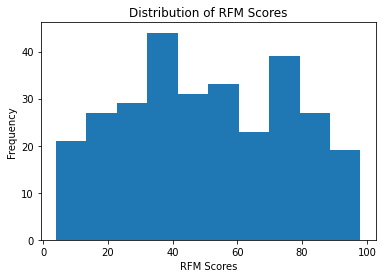

In [ ]:
rfm_table['RFM_Score'].plot.hist()
plt.title('Distribution of RFM Scores')
plt.xlabel('RFM Scores')
plt.ylabel('Frequency')
plt.show()

### 2 segments

In [ ]:
rfm_2 = rfm_table.copy()

In [ ]:
# 0 - 50 - Low valued customer
# 51 - 100 - High valued customer
rfm_2["Cluster"] = np.where(rfm_2['RFM_Score'] > 50 ,"High Value Customer", "Low Value Customer")
rfm_2.head()

,recency,frequency,monetary_value,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Cluster
Name,,,,,,,,,,,
G1M1R1,249,2,2187.0,103.0,40.0,59.0,35.0,14.0,14.0,22.0,Low Value Customer
G1M1R2,195,7,1768.0,125.0,162.0,50.0,43.0,55.0,55.0,50.0,Low Value Customer
G1M1R3,106,5,73573.0,190.0,114.0,278.0,65.0,39.0,39.0,49.0,Low Value Customer
G1M1R4,112,5,4293.0,182.0,114.0,100.0,62.0,39.0,39.0,48.0,Low Value Customer
G1M1R5,363,5,2450.0,70.0,114.0,64.0,24.0,39.0,39.0,33.0,Low Value Customer


In [ ]:
rfm_2['Cluster'].value_counts()

Low Value Customer     152
High Value Customer    141
Name: Cluster, dtype: int64

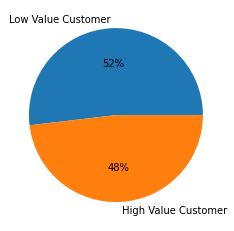

In [ ]:
plt.pie(rfm_2['Cluster'].value_counts(),
        labels=rfm_2['Cluster'].value_counts().index,
        autopct='%.0f%%')
plt.show()

In [ ]:
rfm_2.groupby('Cluster').agg({'recency': 'mean',
                              'frequency': 'mean',
                              'monetary_value': ['mean', 'count']}).round(0)

recency frequency monetary_value      
                       mean      mean           mean count
Cluster                                                   
High Value Customer   112.0      17.0        30782.0   141
Low Value Customer    344.0       4.0        10134.0   152

### 3 segments

In [ ]:
rfm_3 = rfm_table.copy()

In [ ]:
# 0 - 50 - Low Value Customer
# 51 - 75 - Medium Value Customer
# 76 - 100 - High Value Customer
rfm_3["Cluster"] = np.where(rfm_3['RFM_Score'] > 75 ,"High Value Customer",
                               (np.where(rfm_3['RFM_Score'] > 50 , "Medium Value Customer" ,"Low Value Customer")))
rfm_3.head()

,recency,frequency,monetary_value,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Cluster
Name,,,,,,,,,,,
G1M1R1,249,2,2187.0,103.0,40.0,59.0,35.0,14.0,14.0,22.0,Low Value Customer
G1M1R2,195,7,1768.0,125.0,162.0,50.0,43.0,55.0,55.0,50.0,Low Value Customer
G1M1R3,106,5,73573.0,190.0,114.0,278.0,65.0,39.0,39.0,49.0,Low Value Customer
G1M1R4,112,5,4293.0,182.0,114.0,100.0,62.0,39.0,39.0,48.0,Low Value Customer
G1M1R5,363,5,2450.0,70.0,114.0,64.0,24.0,39.0,39.0,33.0,Low Value Customer


In [ ]:
rfm_3['Cluster'].value_counts()

Low Value Customer       152
Medium Value Customer     80
High Value Customer       61
Name: Cluster, dtype: int64

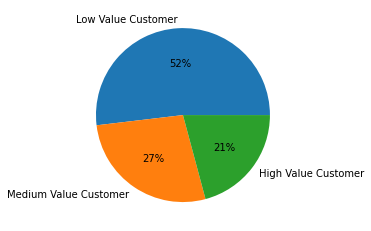

In [ ]:
plt.pie(rfm_3['Cluster'].value_counts(),
        labels=rfm_3['Cluster'].value_counts().index,
        autopct='%.0f%%')
plt.show()

In [ ]:
rfm_3.groupby('Cluster').agg({'recency': 'mean',
                              'frequency': 'mean',
                              'monetary_value': ['mean', 'count']}).round(0)

recency frequency monetary_value      
                         mean      mean           mean count
Cluster                                                     
High Value Customer      66.0      26.0        40311.0    61
Low Value Customer      344.0       4.0        10134.0   152
Medium Value Customer   147.0      10.0        23516.0    80

### 4 segments

In [ ]:
rfm_4 = rfm_table.copy()

In [ ]:
# 0 - 25 - Lost Customer
# 26 - 50 - Low Value Customer
# 51 - 75 - Medium Value Customer
# 76 - 100 - High Value Customer
rfm_4["Cluster"] = np.where(rfm_4['RFM_Score'] > 75 ,"High Value Customer",
                                     (np.where(rfm_4['RFM_Score'] > 50, "Medium Value Customer",
                                               (np.where(rfm_4['RFM_Score'] > 25, "Low Value Customer", "Lost Customer")))))
rfm_4.head()

,recency,frequency,monetary_value,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Cluster
Name,,,,,,,,,,,
G1M1R1,249,2,2187.0,103.0,40.0,59.0,35.0,14.0,14.0,22.0,Lost Customer
G1M1R2,195,7,1768.0,125.0,162.0,50.0,43.0,55.0,55.0,50.0,Low Value Customer
G1M1R3,106,5,73573.0,190.0,114.0,278.0,65.0,39.0,39.0,49.0,Low Value Customer
G1M1R4,112,5,4293.0,182.0,114.0,100.0,62.0,39.0,39.0,48.0,Low Value Customer
G1M1R5,363,5,2450.0,70.0,114.0,64.0,24.0,39.0,39.0,33.0,Low Value Customer


In [ ]:
rfm_4['Cluster'].value_counts()

Low Value Customer       98
Medium Value Customer    80
High Value Customer      61
Lost Customer            54
Name: Cluster, dtype: int64

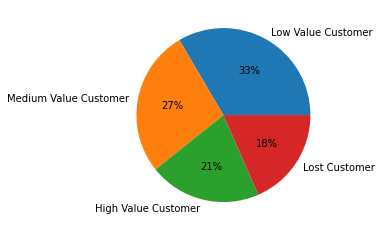

In [ ]:
plt.pie(rfm_4['Cluster'].value_counts(),
        labels=rfm_4['Cluster'].value_counts().index,
        autopct='%.0f%%')
plt.show()

In [ ]:
rfm_4.groupby('Cluster').agg({'recency': 'mean',
                              'frequency': 'mean',
                              'monetary_value': ['mean', 'count']}).round(0)

recency frequency monetary_value      
                         mean      mean           mean count
Cluster                                                     
High Value Customer      66.0      26.0        40311.0    61
Lost Customer           506.0       2.0         7555.0    54
Low Value Customer      255.0       5.0        11555.0    98
Medium Value Customer   147.0      10.0        23516.0    80

### 5 segments

In [ ]:
rfm_5 = rfm_table.copy()

In [ ]:
# 0 - 20 - Lost Customer
# 21 - 40 - Low Value Customer
# 41 - 60 - Medium Value Customer
# 61 - 80 - High Value Customer
# 81 - 100 - Top Customer
rfm_5["Cluster"] = np.where(rfm_5['RFM_Score'] > 80 ,"Top Customer",
                                     (np.where(rfm_5['RFM_Score'] > 60, "High Value Customer",
                                               (np.where(rfm_5['RFM_Score'] > 40, "Medium Value Customer",
                                                         (np.where(rfm_5['RFM_Score'] > 20, "Low Value Customer", "Lost Customer")))))))
rfm_5.head()

,recency,frequency,monetary_value,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Cluster
Name,,,,,,,,,,,
G1M1R1,249,2,2187.0,103.0,40.0,59.0,35.0,14.0,14.0,22.0,Low Value Customer
G1M1R2,195,7,1768.0,125.0,162.0,50.0,43.0,55.0,55.0,50.0,Medium Value Customer
G1M1R3,106,5,73573.0,190.0,114.0,278.0,65.0,39.0,39.0,49.0,Medium Value Customer
G1M1R4,112,5,4293.0,182.0,114.0,100.0,62.0,39.0,39.0,48.0,Medium Value Customer
G1M1R5,363,5,2450.0,70.0,114.0,64.0,24.0,39.0,39.0,33.0,Low Value Customer


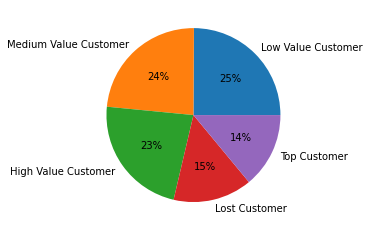

In [ ]:
plt.pie(rfm_5['Cluster'].value_counts(),
        labels=rfm_5['Cluster'].value_counts().index,
        autopct='%.0f%%')
plt.show()

In [ ]:
rfm_5.groupby('Cluster').agg({'recency': 'mean',
                              'frequency': 'mean',
                              'monetary_value': ['mean', 'count']}).round(0)

recency frequency monetary_value      
                         mean      mean           mean count
Cluster                                                     
High Value Customer     110.0      14.0        28881.0    67
Lost Customer           533.0       2.0         7635.0    43
Low Value Customer      298.0       4.0        10181.0    73
Medium Value Customer   198.0       7.0        13734.0    69
Top Customer             57.0      30.0        46988.0    41

## K-means Segmentation (using RFM)
Not used, testing out another segmentation alternative using RFM variables

In [ ]:
# Function to check skewness
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


recency's: Skew: 1.646880403868299, : SkewtestResult(statistic=8.600959495151427, pvalue=7.905238331992933e-18)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


frequency's: Skew: 3.161639100059669, : SkewtestResult(statistic=12.296760812556593, pvalue=9.427966283781106e-35)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


monetary_value's: Skew: 4.285594639771373, : SkewtestResult(statistic=14.094224164733376, pvalue=4.1215245568149087e-45)


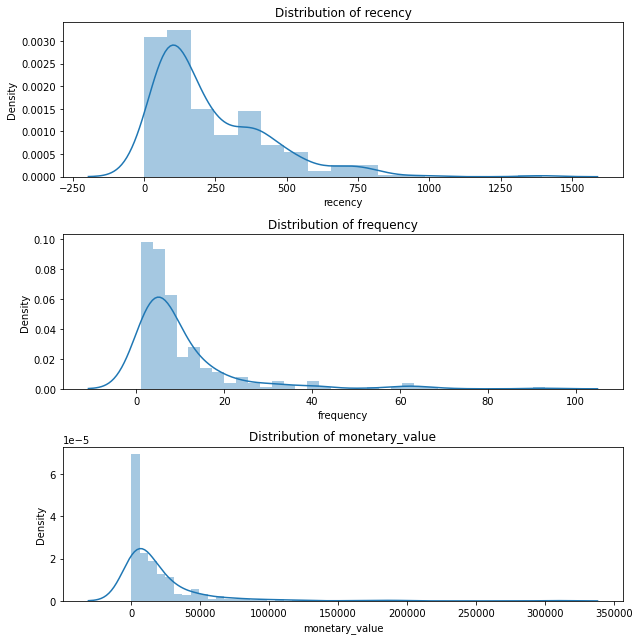

In [ ]:
plt.figure(figsize=(9, 9))
plt.subplot(3, 1, 1)
check_skew(rfm_table,'recency')
plt.subplot(3, 1, 2)
check_skew(rfm_table,'frequency')
plt.subplot(3, 1, 3)
check_skew(rfm_table,'monetary_value')
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

recency's: Skew: -1.3677112242348273, : SkewtestResult(statistic=-7.620278001521312, pvalue=2.5312995522648085e-14)
frequency's: Skew: 0.4369930876569778, : SkewtestResult(statistic=3.0033134338475524, pvalue=0.0026705723307842385)
monetary_value's: Skew: -0.3351459031394079, : SkewtestResult(statistic=-2.3401322124482697, pvalue=0.019276914401318068)


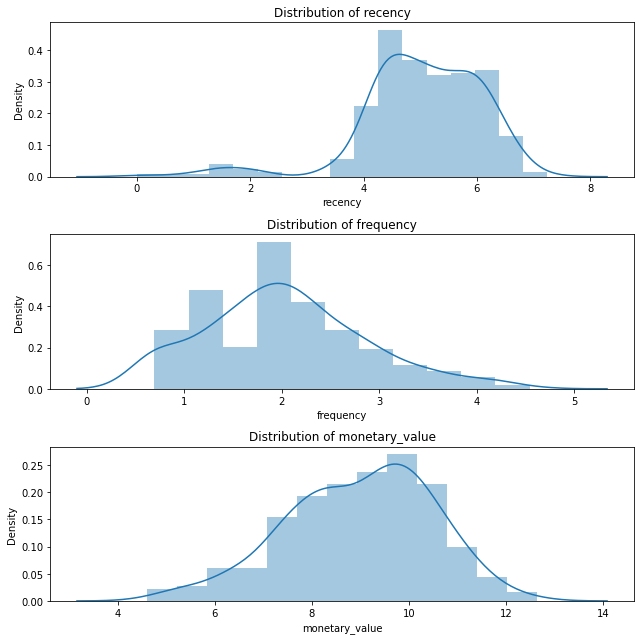

In [ ]:
# All 3 variables are highly skewed, will perform log transformations to reduce the skewness of each variable
# Added a small constant as log transformation demands all the values to be positive
rfm_table_log = rfm_table[['recency', 'frequency', 'monetary_value']].copy()
rfm_table_log = np.log(rfm_table_log+1)
plt.figure(figsize=(9, 9))
plt.subplot(3, 1, 1)
check_skew(rfm_table_log,'recency')
plt.subplot(3, 1, 2)
check_skew(rfm_table_log,'frequency')
plt.subplot(3, 1, 3)
check_skew(rfm_table_log,'monetary_value')
plt.tight_layout()

In [ ]:
# This customer purchased on 9 Dec, thus recency 0; Performing log transformation makes it undefined
rfm_table_log[rfm_table_log['recency'].isnull() == True] = rfm_table_log[rfm_table_log['recency'].isnull() == True].fillna(0)

In [ ]:
# Perform standardization so that all variables are of same scale to allow meaningful K-means clustering
# All the variables now have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
scaler.fit(rfm_table_log)
rfm_table_scaled = scaler.transform(rfm_table_log)

In [ ]:
# Find optimal number of clusters
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(rfm_table_scaled) 
    kmeanModel.fit(rfm_table_scaled)     
      
    distortions.append(sum(np.min(cdist(rfm_table_scaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / rfm_table_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(rfm_table_scaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / rfm_table_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_

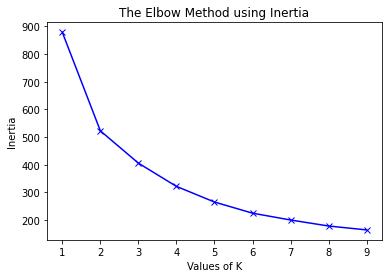

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [ ]:
# rfm_table_k3.groupby('Cluster').agg({'recency': 'mean',
#                               'frequency': 'mean',
#                               'monetary_value': ['mean', 'count']}).round(0)

# Transition Matrix

In [ ]:
# Simulate customers who are present in last quarter
NOW = max(purchase_df['Order Date']) # Use overall latest date of purchase as current time period
purchase_df['Order_Date'] = purchase_df['Order Date'] # Create one more column

last_quarter = NOW - relativedelta(months=3)
purchase_df_last = purchase_df[purchase_df['Order Date'] < last_quarter] # Include those who have purchased before 9 Sep (91 days)
purchase_df_last['Order Date'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  import sys


count                    2794
unique                    759
top       2020-10-16 00:00:00
freq                       45
first     2015-04-21 00:00:00
last      2021-09-08 00:00:00
Name: Order Date, dtype: object

In [ ]:
rfm_table_last = purchase_df_last.groupby('Name').agg({'Order Date': lambda x: (last_quarter - x.max()).days, # Recency (9 Sep - Date of Last Purchase of existing customers) 
                                                                                                             # So those who purchased on 9 Sep will have Recency = 0)
                                        'Order_Date': lambda x: len(x),      # Frequency
                                        'Final Price': lambda x: x.sum()}) # Monetary Value

rfm_table_last.rename(columns={'Order Date': 'recency',
                         'Order_Date': 'frequency', 
                         'Final Price': 'monetary_value'}, inplace=True)

rfm_table_last.head()

,recency,frequency,monetary_value
Name,,,
G1M1R1,158,2,2187.0
G1M1R2,104,7,1768.0
G1M1R3,15,5,73573.0
G1M1R4,21,5,4293.0
G1M1R5,272,5,2450.0


In [ ]:
# Around 5 customers are new in last quarter
print(rfm_table.shape)
print(rfm_table_last.shape)

(293, 10)
(288, 3)


In [ ]:
# Rank each metric R, F & M
rfm_table_last['R_rank'] = rfm_table_last['recency'].rank( ascending=False)
rfm_table_last['F_rank'] = rfm_table_last['frequency'].rank(ascending=True)
rfm_table_last['M_rank'] = rfm_table_last['monetary_value'].rank(ascending=True)
rfm_table_last.head()

,recency,frequency,monetary_value,R_rank,F_rank,M_rank
Name,,,,,,
G1M1R1,158,2,2187.0,116.0,39.0,59.0
G1M1R2,104,7,1768.0,145.0,166.5,50.0
G1M1R3,15,5,73573.0,249.5,116.0,274.0
G1M1R4,21,5,4293.0,238.0,116.0,101.0
G1M1R5,272,5,2450.0,77.0,116.0,65.0


In [ ]:
# Normalize each rank with Max rank
rfm_table_last['R_rank_norm'] = (rfm_table_last['R_rank']/rfm_table_last['R_rank'].max())*100
rfm_table_last['F_rank_norm'] = (rfm_table_last['F_rank']/rfm_table_last['F_rank'].max())*100
rfm_table_last['M_rank_norm'] = (rfm_table_last['F_rank']/rfm_table_last['M_rank'].max())*100
rfm_table_last.head()

,recency,frequency,monetary_value,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm
Name,,,,,,,,,
G1M1R1,158,2,2187.0,116.0,39.0,59.0,40.630473,13.541667,13.541667
G1M1R2,104,7,1768.0,145.0,166.5,50.0,50.788091,57.812500,57.812500
G1M1R3,15,5,73573.0,249.5,116.0,274.0,87.390543,40.277778,40.277778
G1M1R4,21,5,4293.0,238.0,116.0,101.0,83.362522,40.277778,40.277778
G1M1R5,272,5,2450.0,77.0,116.0,65.0,26.970228,40.277778,40.277778


In [ ]:
# Apply defined weights to create final RFM score for customers present in last quarter
rfm_table_last['RFM_Score'] = r_weight*rfm_table_last['R_rank_norm'] + f_weight * rfm_table_last['F_rank_norm'] + m_weight * rfm_table_last['M_rank_norm']
rfm_table_last = rfm_table_last.round(0)
rfm_table_last.head()

,recency,frequency,monetary_value,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
Name,,,,,,,,,,
G1M1R1,158,2,2187.0,116.0,39.0,59.0,41.0,14.0,14.0,24.0
G1M1R2,104,7,1768.0,145.0,166.0,50.0,51.0,58.0,58.0,55.0
G1M1R3,15,5,73573.0,250.0,116.0,274.0,87.0,40.0,40.0,59.0
G1M1R4,21,5,4293.0,238.0,116.0,101.0,83.0,40.0,40.0,58.0
G1M1R5,272,5,2450.0,77.0,116.0,65.0,27.0,40.0,40.0,35.0


In [ ]:
rfm_4_last = rfm_table_last.copy()

In [ ]:
rfm_4_last["Cluster"] = np.where(rfm_4_last['RFM_Score'] > 75 ,"High Value Customer",
                            (np.where(rfm_4_last['RFM_Score'] > 50, "Medium Value Customer",
                            (np.where(rfm_4_last['RFM_Score'] > 25, "Low Value Customer", "Lost Customer")))))
rfm_4_last.head()

,recency,frequency,monetary_value,R_rank,F_rank,M_rank,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Cluster
Name,,,,,,,,,,,
G1M1R1,158,2,2187.0,116.0,39.0,59.0,41.0,14.0,14.0,24.0,Lost Customer
G1M1R2,104,7,1768.0,145.0,166.0,50.0,51.0,58.0,58.0,55.0,Medium Value Customer
G1M1R3,15,5,73573.0,250.0,116.0,274.0,87.0,40.0,40.0,59.0,Medium Value Customer
G1M1R4,21,5,4293.0,238.0,116.0,101.0,83.0,40.0,40.0,58.0,Medium Value Customer
G1M1R5,272,5,2450.0,77.0,116.0,65.0,27.0,40.0,40.0,35.0,Low Value Customer


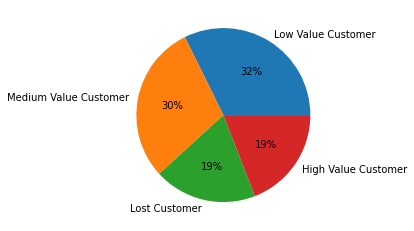

In [ ]:
plt.pie(rfm_4_last['Cluster'].value_counts(),
        labels=rfm_4_last['Cluster'].value_counts().index,
        autopct='%.0f%%')
plt.show()

In [ ]:
# Compute transition matrix
rfm_4_overall = rfm_4_last.join(rfm_4, lsuffix='_last')
rfm_4_overall[['Cluster_last', 'Cluster']].head()

,Cluster_last,Cluster
Name,,
G1M1R1,Lost Customer,Lost Customer
G1M1R2,Medium Value Customer,Low Value Customer
G1M1R3,Medium Value Customer,Low Value Customer
G1M1R4,Medium Value Customer,Low Value Customer
G1M1R5,Low Value Customer,Low Value Customer


In [ ]:
rfm_4_transition = pd.crosstab(rfm_4_overall['Cluster_last'], rfm_4_overall['Cluster'])
rowsum_4 = rfm_4_transition.sum(axis=1)
for i in range(4):
  rfm_4_transition.iloc[i] /= rowsum_4[i]
rfm_4_transition.head()

Cluster,High Value Customer,Lost Customer,Low Value Customer,Medium Value Customer
Cluster_last,,,,
High Value Customer,0.690909,0.000000,0.000000,0.309091
Lost Customer,0.000000,0.890909,0.090909,0.018182
Low Value Customer,0.032258,0.053763,0.817204,0.096774
Medium Value Customer,0.235294,0.000000,0.141176,0.623529


In [ ]:
order_4 = ['High Value Customer', 'Medium Value Customer', 'Low Value Customer', 'Lost Customer']
rfm_4_transition_final = rfm_4_transition.reindex(order_4, columns=order_4, fill_value=0)
rfm_4_transition_final

Cluster,High Value Customer,Medium Value Customer,Low Value Customer,Lost Customer
Cluster_last,,,,
High Value Customer,0.690909,0.309091,0.000000,0.000000
Medium Value Customer,0.235294,0.623529,0.141176,0.000000
Low Value Customer,0.032258,0.096774,0.817204,0.053763
Lost Customer,0.000000,0.018182,0.090909,0.890909


# Customer Lifetime Value (CLV)

In [ ]:
# Filter data from last quarter onwards
purchase_quarter = purchase_df[purchase_df['Order Date'] >= last_quarter] # Include revenue generated from 9 Sep
purchase_quarter['Order Date'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  This is separate from the ipykernel package so we can avoid doing imports until


count                     175
unique                     47
top       2021-10-02 00:00:00
freq                       16
first     2021-09-09 00:00:00
last      2021-12-09 00:00:00
Name: Order Date, dtype: object

In [ ]:
# Calculate earned revenue from last quarter onwards
revenue_last = purchase_quarter.groupby('Name').agg({'Final Price': lambda x: x.sum()}) # Monetary Value
revenue_last.rename(columns={'Final Price': 'monetary_value'}, inplace=True)
revenue_last.head()

,monetary_value
Name,
G1M1R9,595.0
G1M2R1,390.0
G1M2R10,1902.0
G1M2R12,1001.9
G1M2R2,7238.0


In [ ]:
# Combine last quarter revenue with data
rfm_4_lastQ = rfm_4.join(revenue_last, rsuffix='_lastQ')
rfm_4_lastQ.fillna(0, inplace=True)
rfm_4_lastQ[['Cluster', 'monetary_value_lastQ']].head()

,Cluster,monetary_value_lastQ
Name,,
G1M1R1,Lost Customer,0.0
G1M1R2,Low Value Customer,0.0
G1M1R3,Low Value Customer,0.0
G1M1R4,Low Value Customer,0.0
G1M1R5,Low Value Customer,0.0


In [ ]:
# Mean revenue for each segment in last quarter
rfm_4_mean_rev = rfm_4_lastQ.groupby('Cluster')['monetary_value_lastQ'].mean()
revenue_order_4 = np.zeros((4,4))
np.fill_diagonal(revenue_order_4, rfm_4_mean_rev.sort_values(ascending=False))
revenue_order_4

array([[2968.17885246,    0.        ,    0.        ,    0.        ],
       [   0.        ,  532.270125  ,    0.        ,    0.        ],
       [   0.        ,    0.        ,  362.66326531,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ]])

In [ ]:
# Predict future customers
segment_matrix_4 = np.zeros((4,6))
segment_matrix_4

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [ ]:
rfm_4['Cluster'].value_counts()

Low Value Customer       98
Medium Value Customer    80
High Value Customer      61
Lost Customer            54
Name: Cluster, dtype: int64

In [ ]:
segment_matrix_4[:,0] = [61,80,98,54]
for i in range(1,6):
  segment_matrix_4[:,i] = np.dot(segment_matrix_4[:,i-1],rfm_4_transition_final)
segment_matrix_4

array([[61.        , 64.13027428, 66.05019665, 67.39518376, 68.42681122,
        69.26158293],
       [80.        , 79.20258755, 79.49604761, 80.10904756, 80.76938003,
        81.38793996],
       [98.        , 96.28923006, 94.72205183, 93.42403085, 92.38982678,
        91.57809819],
       [54.        , 53.37790811, 52.73170392, 52.07173783, 51.41398197,
        50.77237893]])

In [ ]:
# Quarter revenue for each segment
q_revenue_4 = np.matmul(revenue_order_4,segment_matrix_4)
q_revenue_4

array([[181058.91      , 190350.1239197 , 196048.79689661,
        200040.9591898 , 203103.01399823, 205580.76574862],
       [ 42581.61      ,  42157.17117305,  42313.37119656,
         42639.65275818,  42991.12800551,  43320.3689739 ],
       [ 35541.        ,  34920.56658793,  34352.20861165,
         33881.46408641,  33506.3962611 ,  33212.01211852],
       [     0.        ,      0.        ,      0.        ,
             0.        ,      0.        ,      0.        ]])

In [ ]:
# Cumulative revenue for each segment, look at last index of each []
cumulative_revenue_4 = np.cumsum(q_revenue_4,axis=1)
cumulative_revenue_4

array([[ 181058.91      ,  371409.0339197 ,  567457.83081631,
         767498.79000611,  970601.80400434, 1176182.56975296],
       [  42581.61      ,   84738.78117305,  127052.15236962,
         169691.8051278 ,  212682.93313331,  256003.30210721],
       [  35541.        ,   70461.56658793,  104813.77519957,
         138695.23928599,  172201.63554708,  205413.6476656 ],
       [      0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ]])

In [ ]:
# Convert annual discount rate to period discount rate
yearly_discount_rate = 0.25
n_periods = 4 # Quarterly

discount_rate = ((1 + yearly_discount_rate)**(1/n_periods)) - 1
discount_rate

0.05737126344056409

In [ ]:
# Discounted quarter revenue for each segment
discount = []
for i in range(1,7):
  discount.append(1 / ((1 + discount_rate)**(i - 1)))
print(discount)
discounted_q_revenue_4 = q_revenue_4*discount
discounted_q_revenue_4

[1.0, 0.9457416090031758, 0.894427190999916, 0.8458970107524514, 0.8000000000000002, 0.7565932872025408]


array([[181058.91      , 180022.03246977, 175351.37470715,
        169214.04940671, 162482.41119858, 155541.02734336],
       [ 42581.61      ,  39869.79089622,  37846.22974108,
         36068.75480767,  34392.90240441,  32775.90036479],
       [ 35541.        ,  33025.83283217,  30725.54945316,
         28660.22919061,  26805.11700888,  25127.98542336],
       [     0.        ,      0.        ,      0.        ,
             0.        ,      0.        ,      0.        ]])

In [ ]:
# Cumulative discounted revenue for each segment, look at last index of each []
discounted_cumulative_revenue_4 = np.cumsum(discounted_q_revenue_4,axis=1)
discounted_cumulative_revenue_4

array([[ 181058.91      ,  361080.94246977,  536432.31717692,
         705646.36658362,  868128.77778221, 1023669.80512557],
       [  42581.61      ,   82451.40089622,  120297.6306373 ,
         156366.38544497,  190759.28784938,  223535.18821417],
       [  35541.        ,   68566.83283217,   99292.38228533,
         127952.61147594,  154757.72848482,  179885.71390818],
       [      0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ]])

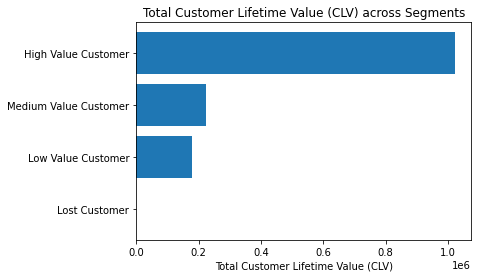

In [ ]:
# Total CLV of each segment
plt.barh(order_4[::-1], [x[-1] for x in discounted_cumulative_revenue_4][::-1])
plt.title('Total Customer Lifetime Value (CLV) across Segments')
plt.xlabel('Total Customer Lifetime Value (CLV)')
plt.show()

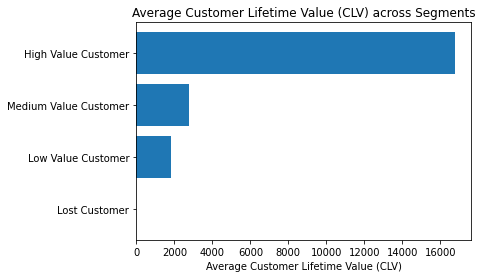

In [ ]:
# Average CLV of each segment
plt.barh(order_4[::-1], [x[-1] for x in np.divide(discounted_cumulative_revenue_4, np.flip(segment_matrix_4, axis=1))][::-1])
plt.title('Average Customer Lifetime Value (CLV) across Segments')
plt.xlabel('Average Customer Lifetime Value (CLV)')
plt.show()

In [ ]:
# Exact total CLV value
total_clv = [x[-1] for x in discounted_cumulative_revenue_4]
total_clv

[1023669.805125569, 223535.18821416853, 179885.71390817966, 0.0]

In [ ]:
# Exact average CLV value
avg_clv = [x[-1] for x in np.divide(discounted_cumulative_revenue_4,np.flip(segment_matrix_4,axis=1))]
avg_clv

[16781.472215173264, 2794.1898526771065, 1835.5685092671395, 0.0]

# Customer Base Lifetime Value (CBLV)

In [ ]:
pop_customers = 350000000
sample_customers = 293

multiplier = round(pop_customers/sample_customers)
multiplier

1194539

In [ ]:
sum(total_clv)

1427090.707247917

In [ ]:
sum(total_clv)*multiplier

1704715506345.2197

# Export customers and segment

In [ ]:
export_columns = ['Name', 'recency', 'frequency', 'monetary_value', 'Cluster']

### 2 segments

In [ ]:
RFM_2_segment = pd.DataFrame(rfm_2.reset_index()[export_columns])
print(RFM_2_segment.shape)
RFM_2_segment.head()

(293, 5)


,Name,recency,frequency,monetary_value,Cluster
0,G1M1R1,249,2,2187.0,Low Value Customer
1,G1M1R2,195,7,1768.0,Low Value Customer
2,G1M1R3,106,5,73573.0,Low Value Customer
3,G1M1R4,112,5,4293.0,Low Value Customer
4,G1M1R5,363,5,2450.0,Low Value Customer


In [ ]:
# # Save to CSV
# RFM_2_segment.to_csv("Data/RFM_2_segment.csv", index=False)

### 3 segments

In [ ]:
RFM_3_segment = pd.DataFrame(rfm_3.reset_index()[export_columns])
print(RFM_3_segment.shape)
RFM_3_segment.head()

(293, 5)


,Name,recency,frequency,monetary_value,Cluster
0,G1M1R1,249,2,2187.0,Low Value Customer
1,G1M1R2,195,7,1768.0,Low Value Customer
2,G1M1R3,106,5,73573.0,Low Value Customer
3,G1M1R4,112,5,4293.0,Low Value Customer
4,G1M1R5,363,5,2450.0,Low Value Customer


In [ ]:
# # Save to CSV
# RFM_3_segment.to_csv("Data/RFM_3_segment.csv", index=False)

### 4 segments

In [ ]:
RFM_4_segment = pd.DataFrame(rfm_4.reset_index()[export_columns])
print(RFM_4_segment.shape)
RFM_4_segment.head()

(293, 5)


,Name,recency,frequency,monetary_value,Cluster
0,G1M1R1,249,2,2187.0,Lost Customer
1,G1M1R2,195,7,1768.0,Low Value Customer
2,G1M1R3,106,5,73573.0,Low Value Customer
3,G1M1R4,112,5,4293.0,Low Value Customer
4,G1M1R5,363,5,2450.0,Low Value Customer


In [ ]:
# # Save to CSV
# RFM_4_segment.to_csv("Data/RFM_4_segment.csv", index=False)

### 5 segments

In [ ]:
RFM_5_segment = pd.DataFrame(rfm_5.reset_index()[export_columns])
print(RFM_5_segment.shape)
RFM_5_segment.head()

(293, 5)


,Name,recency,frequency,monetary_value,Cluster
0,G1M1R1,249,2,2187.0,Low Value Customer
1,G1M1R2,195,7,1768.0,Medium Value Customer
2,G1M1R3,106,5,73573.0,Medium Value Customer
3,G1M1R4,112,5,4293.0,Medium Value Customer
4,G1M1R5,363,5,2450.0,Low Value Customer


In [ ]:
# # Save to CSV
# RFM_5_segment.to_csv("Data/RFM_5_segment.csv", index=False)